##### Setup (imports, constants, etc.)

In [5]:
from copy import deepcopy
import pdb
import warnings
from importlib import reload
import random
from copy import deepcopy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (StratifiedShuffleSplit, train_test_split,
                                     validation_curve)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, make_scorer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from IPython.display import display
import xgboost as xgb

import pdir

from outlier_detection import *
from preprocessing import *
from validation_plots import *
from main import read_rental_interest, feature_prep

%matplotlib inline

%load_ext autoreload
%autoreload 2

pd.set_option('display.float_format', lambda x: '%.5f' % x)

SEED = 42
np.random.seed(SEED)

DAT_DIR = '../Data/'
SUBM_DIR = '../Submissions/'
TEST_DIR = '../Tests/'
REPORT_IMG_DIR = '../Report-Images/'

TRAIN_FP = ''.join([DAT_DIR, 'train.json'])
TEST_FP = ''.join([DAT_DIR, 'test.json'])
SAMPLE_FP = ''.join([DAT_DIR, 'sample_submission.csv'])
DF_TRAIN_PKL = ''.join([DAT_DIR, 'df_train.pkl'])
DF_TEST_PKL = ''.join([DAT_DIR, 'df_test.pkl'])

scorer_acc = make_scorer(accuracy_score)

# using built-in 'neg_log_loss' scoring param used for simplicity
# source code show exact same make_scorer call, kept for reference
scorer = make_scorer(log_loss, greater_is_better=False,
                     needs_proba=True)

scoring = 'neg_log_loss'

df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from preprocessing import *


extractor = FeatureUnion([
    ('dense', Pipeline([
        ('extract', FeatureUnion([
            ('basic', FeatureUnion([
                ('coordinates', make_pipeline(
                    ItemSelector(['latitude', 'longitude']),
                    LatLongImputer(),
                )),
                ('pre_processed', ItemSelector(
                    ['lg_price', 'n_photos', 'n_feats', 'descr_wcnt'])),
                ('rooms', make_pipeline(
                    ItemSelector(['bathrooms', 'bedrooms']),
                    BedBathImputer())),   
                ])),

#             ('aggregate', make_pipeline(
#                 FeatureUnion([
#                     ('n_posts', make_pipeline(
#                         ItemSelector(['manager_id']),
#                         GroupSumExtractor())),
#                     ('building_activity', make_pipeline(
#                         ItemSelector(['building_id']),
#                         GroupSumExtractor()))
#                     ]),
#                 LogTransformer(),
#             )),
        ])),
        ('standardize', StandardScaler())
    ])),

    ('sparse', FeatureUnion([
        ('day_names', ItemSelector([
            'created_Friday', 'created_Monday', 'created_Saturday',
            'created_Sunday', 'created_Thursday', 'created_Tuesday',
            'created_Wednesday'
            ])
        ),
        ('flags', ItemSelector(['no_photo', 'no_feats', 'no_desc']))
        
    ])),
])

In [13]:
df = read_rental_interest(DF_TRAIN_PKL)

X_, y = df.drop('interest_level', axis=1), df.interest_level

X = feature_prep(X_, basic_imputes=-999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=.8, random_state=SEED, stratify=y)

xgb_clf = xgb.XGBClassifier(objective='multi:softprob', silent=1,
                            nthread=1, seed=SEED, missing=-999)

pipe = Pipeline([
    ('extractor', extractor),
#     ('to_frame', ToFrame(columns)),
    ('xgb', xgb_clf)
])


parameters = dict(
    xgb__n_estimators=[50, 100, 150],
    xgb__learning_rate=[0.05, .1],
    xgb__max_depth=[3, 4],
    
)

# cv = StratifiedShuffleSplit(n_splits=5, train_size=.4, random_state=SEED)
cv = None
grid = GridSearchCV(pipe, parameters, fit_params=None,
                    scoring=scoring, n_jobs=-1, cv=cv)

grid.fit(X_train, y_train)

print()
print(best_grid_results(grid))

clf = grid.best_estimator_


Best score: -0.62831

*** For parameters: ***
xgb__max_depth: 4
xgb__n_estimators: 150
xgb__learning_rate: 0.1


In [95]:
# grid2d = deepcopy(grid)

In [14]:
g = GridSearchExplorer(grid)

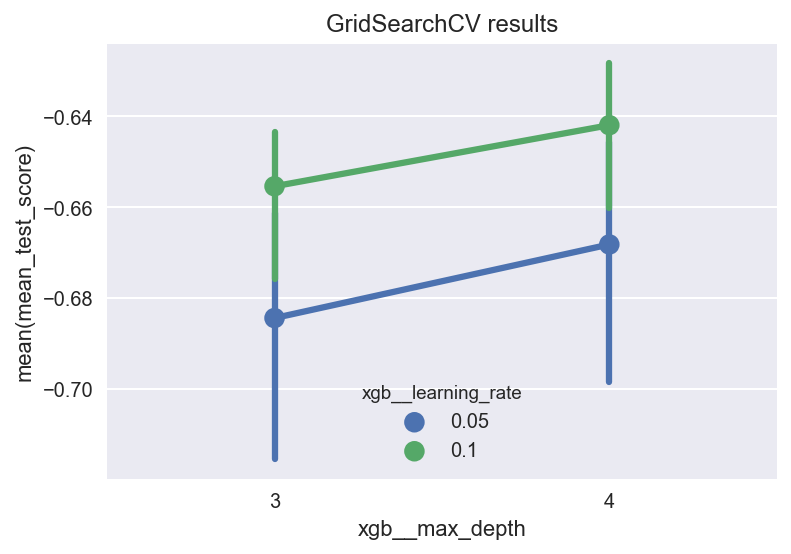

In [15]:
g.plot('xgb__max_depth', hue='xgb__learning_rate', kind='point')

In [122]:
d = g.plot_data
# d = d.set_index(['xgb__max_depth', 'xgb__learning_rate'])
# d = d.unstack('xgb__max_depth')
d

xgb__max_depth                              3        4        5
xgb__learning_rate xgb__n_estimators                           
0.05000            50                -0.71539 -0.69842 -0.68482
                   100               -0.67659 -0.66052 -0.64881
0.10000            50                -0.67572 -0.66027 -0.64818
                   100               -0.65082 -0.63717 -0.62830

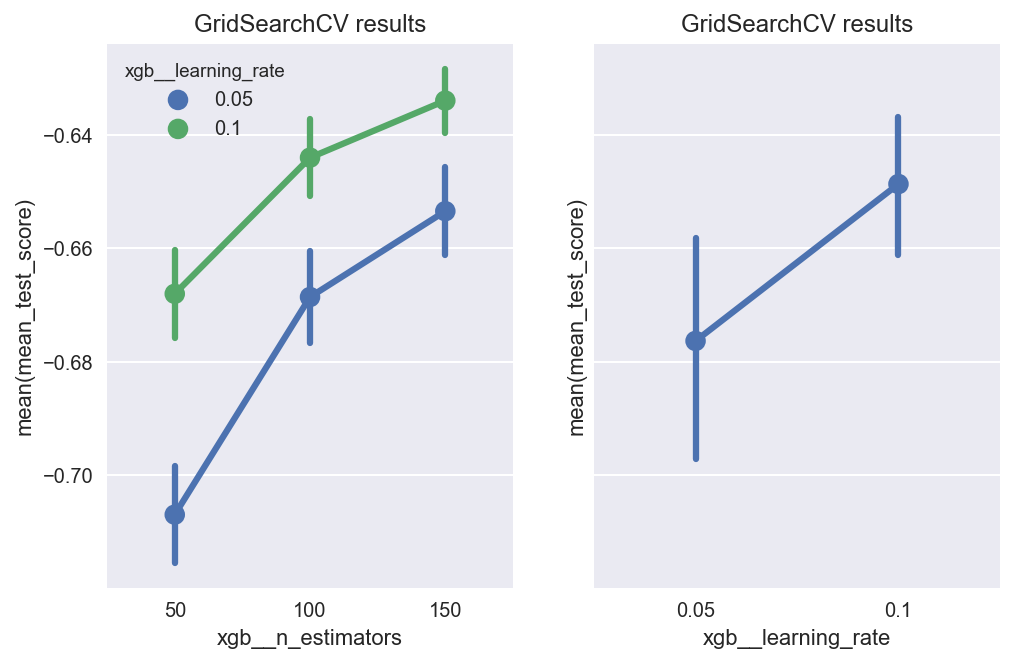

In [16]:
f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(8, 5))

g.plot('xgb__n_estimators', 'xgb__learning_rate', ax=ax1, kind='point')
g.plot('xgb__learning_rate', None, ax=ax2, kind='point')
plt.show()

In [44]:
df = read_rental_interest(DF_TRAIN_PKL)

X_, y = df.drop('interest_level', axis=1), df.interest_level

X = feature_prep(X_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.20, random_state=SEED, stratify=y)

pipe = Pipeline([
    ('extractor', extractor),
    ('lr_clf', LogisticRegression(
        random_state=SEED, multi_class='multinomial',
        warm_start=True, max_iter=100, 
        solver='lbfgs'))
])

parameters = dict(
    lr_clf__C=np.logspace(-4, 4, 10),
    lr_clf__solver=['newton-cg', 'lbfgs'],
)

cv = StratifiedShuffleSplit(n_splits=5, train_size=.4, random_state=SEED)
grid = GridSearchCV(pipe, parameters, n_jobs=-1, scoring=scoring,
                    error_score=np.nan, cv=cv)


grid.fit(X_train, y_train)

print(best_grid_results(grid))

Best score: -0.69402

*** For parameters: ***
lr_clf__solver: newton-cg
lr_clf__C: 0.3593813663804626


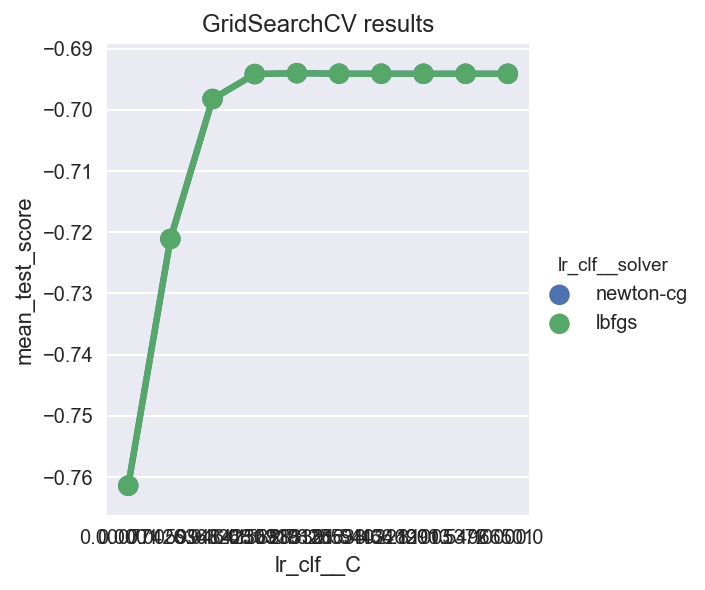

In [46]:
g = GridSearchExplorer(grid)
g.plot(x='lr_clf__C', hue='lr_clf__solver')

In [ ]:
sns.factorplot